# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import statsmodels.formula.api as smf 
import re


# Load Data

In [2]:
file_dir = "/Users/huayinluo/Desktop/code/natconv"
csv1 = pd.read_csv(f"{file_dir}/combinedSurvey.csv")
csv1 = csv1.rename(columns={'convo_id': 'conversation'}) # rename column
csv2 = pd.read_csv(f"{file_dir}/backchannel.csv")
df = pd.merge(csv1, csv2, on='conversation') # merge based on conversation id
df = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y']) # drop columns


In [3]:
df["backchannel_count"] = df["backchannel_given"] + df["backchannel_recieved"]

In [4]:
df.to_csv(f"{file_dir}/natconv.csv")

In [5]:
df.head()

,user_id,partner_id,conversation,date,survey_duration_in_seconds,time_zone,pre_affect,pre_arousal,technical_quality,conv_length,...,your_agreeable,your_conscientious,your_neurotic,your_open,who_i_talked_to_most_past24,most_common_format_past24,speaker,backchannel_given,backchannel_recieved,backchannel_count
0,5a73899f9cdd1800017786f0,5fa072f4f4aa580b63834357,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,4115,6.0,5.0,4.0,1.0,45.0,...,4.000000,4.666667,3.000000,4.666667,NaN,NaN,5a73899f9cdd1800017786f0,269,83,352
1,5a73899f9cdd1800017786f0,5fa072f4f4aa580b63834357,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,4115,6.0,5.0,4.0,1.0,45.0,...,4.000000,4.666667,3.000000,4.666667,NaN,NaN,5fa072f4f4aa580b63834357,83,269,352
2,5fa072f4f4aa580b63834357,5a73899f9cdd1800017786f0,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,3949,6.0,7.0,6.0,1.0,43.0,...,4.000000,4.333333,2.666667,3.666667,NaN,NaN,5a73899f9cdd1800017786f0,269,83,352
3,5fa072f4f4aa580b63834357,5a73899f9cdd1800017786f0,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,3949,6.0,7.0,6.0,1.0,43.0,...,4.000000,4.333333,2.666667,3.666667,NaN,NaN,5fa072f4f4aa580b63834357,83,269,352
4,5f482b0da1cde52de45f174c,5f57120cba207c18f058a62b,002d68da-7738-4177-89d9-d72ae803e0e4,2020-11-15,3293,8.0,7.0,6.0,1.0,34.0,...,3.666667,2.666667,4.000000,4.000000,NaN,NaN,5f482b0da1cde52de45f174c,76,96,172


# Preprocessing


## Data Dictionary

In [6]:
datadict = pd.read_csv("datadict.csv")
datadict

,column,text,sub_questions,type,selector,sub_selector,choices,notes
0,user_id,The ID of the respondent.,NaN,NaN,NaN,NaN,NaN,NaN
1,partner_id,The ID of the respondent's partner.,NaN,NaN,NaN,NaN,NaN,NaN
2,convo_id,The ID of the conversation.,NaN,NaN,NaN,NaN,NaN,NaN
3,date,The date of the survey.,NaN,NaN,NaN,NaN,NaN,NaN
4,survey_duration_in_seconds,Amount of time taken to complete the survey.,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
224,your_conscientious,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
225,your_neurotic,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
226,your_open,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
227,who_i_talked_to_most_past24,Who were your conversations with? In other wor...,none,constant sum,number entry,text box,"Family, Romantic Partner, Friends, Work Collea...",NaN


In [7]:
questions = datadict.groupby("text").count().sort_values("column", ascending=False)["column"].index # get questions with most subquestions
question_dct = {}
for question in questions:
    question_dct[question] = datadict[datadict["text"] == question]["column"].values    

In [8]:
for key, value in question_dct.items():
    print(key)
    print(value)
    print("\n")

Now, please tell us where you think your conversation partner falls on these items. My conversation partner is...
['your_bfi_1' 'your_bfi_2' 'your_bfi_3' 'your_bfi_4' 'your_bfi_5'
 'your_bfi_6' 'your_bfi_7' 'your_bfi_8' 'your_bfi_9' 'your_bfi_10'
 'your_bfi_11' 'your_bfi_12' 'your_bfi_13' 'your_bfi_14' 'your_bfi_15'
 'your_extraversion' 'your_agreeable' 'your_conscientious' 'your_neurotic'
 'your_open']


I am someone who...
['my_bfi_1' 'my_bfi_2' 'my_bfi_3' 'my_bfi_4' 'my_bfi_5' 'my_bfi_6'
 'my_bfi_7' 'my_bfi_8' 'my_bfi_9' 'my_bfi_10' 'my_bfi_11' 'my_bfi_12'
 'my_bfi_13' 'my_bfi_14' 'my_bfi_15' 'my_extraversion' 'my_agreeable'
 'my_conscientious' 'my_neurotic' 'my_open']


How would you rate yourself on each of the following traits?
['i_am_intelligent' 'i_am_quickwitted' 'i_am_competent' 'i_am_kind'
 'i_am_friendly' 'i_am_warm' 'i_am_humble' 'i_am_giving' 'i_am_fair'
 'i_am_trustworthy' 'i_am_agreeable' 'i_am_playful']


Please rate your agreement with the following statements about y

In [9]:
from itertools import groupby
likert = datadict[datadict["selector"]=="likert"]["column"]
likert = [list(g) for k, g in groupby(likert, key=lambda x: x[:2])]
for lst in likert:
    print(lst)


['i_felt_close_to_my_partner', 'i_would_like_to_become_friends', 'i_paid_attention_to_my_partner']
['my_partner_paid_attention_to_me', 'my_partner_was_clear_and_coherent']
['you_are_intelligent', 'you_are_quickwitted', 'you_are_competent', 'you_are_kind', 'you_are_friendly', 'you_are_warm', 'you_think_i_am_intelligent', 'you_think_i_am_quickwitted', 'you_think_i_am_competent', 'you_think_i_am_kind', 'you_think_i_am_friendly', 'you_think_i_am_warm', 'you_are_humble', 'you_are_giving', 'you_are_fair', 'you_are_trustworthy', 'you_are_agreeable', 'you_are_playful']
['i_am_intelligent', 'i_am_quickwitted', 'i_am_competent', 'i_am_kind', 'i_am_friendly', 'i_am_warm', 'i_am_humble', 'i_am_giving', 'i_am_fair', 'i_am_trustworthy', 'i_am_agreeable', 'i_am_playful']
['our_thoughts_synced_up_sr1']
['developed_joint_perspective_sr2']
['shared_thoughts_feels_sr3']
['discussed_real_things_sr4']
['thoughts_became_more_alike_sr5']
['anticipated_each_other_sr6']
['became_certain_of_perception_sr7']
['s

In [10]:
datadict

,column,text,sub_questions,type,selector,sub_selector,choices,notes
0,user_id,The ID of the respondent.,NaN,NaN,NaN,NaN,NaN,NaN
1,partner_id,The ID of the respondent's partner.,NaN,NaN,NaN,NaN,NaN,NaN
2,convo_id,The ID of the conversation.,NaN,NaN,NaN,NaN,NaN,NaN
3,date,The date of the survey.,NaN,NaN,NaN,NaN,NaN,NaN
4,survey_duration_in_seconds,Amount of time taken to complete the survey.,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
224,your_conscientious,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
225,your_neurotic,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
226,your_open,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
227,who_i_talked_to_most_past24,Who were your conversations with? In other wor...,none,constant sum,number entry,text box,"Family, Romantic Partner, Friends, Work Collea...",NaN


In [11]:
datadict[datadict["type"].notna()].groupby("type").count()

,column,text,sub_questions,selector,sub_selector,choices,notes
type,,,,,,,
constant sum,14,14,14,14,14,14,0
descriptive block,1,1,1,1,1,1,0
matrix table,96,96,96,96,96,96,0
multiple choice,91,91,91,91,91,91,1
slider,5,5,5,5,5,4,0
text entry,16,16,16,16,16,16,0


In [12]:
# 
datadict[datadict["type"].notna()].groupby("selector").count()

,column,text,sub_questions,type,sub_selector,choices,notes
selector,,,,,,,
horizontal slider,5,5,5,5,5,4,0
likert,96,96,96,96,96,96,0
number entry,14,14,14,14,14,14,0
single answer horizontal,61,61,61,61,61,61,1
single answer vertical,30,30,30,30,30,30,0
slider,9,9,9,9,9,9,0
text box,8,8,8,8,8,8,0


In [13]:
datadict[datadict["choices"].notna()].groupby("choices").count()

,column,text,sub_questions,type,selector,sub_selector,notes
choices,,,,,,,
&nbsp;,3,3,3,3,3,3,0
"0 - Does not describe me at all, 1 - Does not describe me, 2 - Describes me somewhat, 3 - Describes me well, 4 - Describes me very well",2,2,2,2,2,2,0
"0, 1, 2, 3, 4, 5, 6, 7",1,1,1,1,1,1,1
"1 - Disagree strongly, 2 - Disagree a little, 3 - Neutral; no opinion, 4 - Agree a little, 5 - Agree strongly",40,40,40,40,40,40,0
"1 - Extremely bad, 2, 3, 4, 5, 6, 7, 8, 9 - Extremely good",4,4,4,4,4,4,0
"1 - Extremely low, 2, 3, 4, 5, 6, 7, 8, 9 - Extremely high",9,9,9,9,9,9,0
"1 - Extremely negative, 2, 3, 4, 5, 6, 7, 8, 9 - Extremely positive",10,10,10,10,10,10,0
"1 - I asked many more questions than my partner did, 2, 3, 4, 5 - We asked the exact same amount of questions, 6, 7, 8, 9 - My partner asked more questions than I did",1,1,1,1,1,1,0
"1 - I did this much more than my partner did, 2, 3, 4, 5 - We did this the exact same amount, 6, 7, 8, 9 - My partner did this much more than I did",1,1,1,1,1,1,0


In [14]:
import re
datadict_int= datadict[datadict["choices"].notna()].copy()
datadict_int["int_choices"] = datadict_int["choices"].apply(lambda x: re.findall(r'\d+', x))
datadict_int["int_choices_len"] = datadict_int["int_choices"].apply(lambda x: len(x))
datadict_int["int_choices"] = [','.join(map(str, l)) for l in datadict_int['int_choices']]
datadict_int.groupby("int_choices").count()

,column,text,sub_questions,type,selector,sub_selector,choices,notes,int_choices_len
int_choices,,,,,,,,,
,73,73,73,73,73,73,73,0,73
"0,1,2,3,4",2,2,2,2,2,2,2,0,2
"0,1,2,3,4,5,6,7",1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2,0,2
"1,1,2,3,4",1,1,1,1,1,1,1,0,1
"1,2,3,4,5",40,40,40,40,40,40,40,0,40
"1,2,3,4,5,6,7",20,20,20,20,20,20,20,0,20
"1,2,3,4,5,6,7,8,9",76,76,76,76,76,76,76,0,76
"10,00,9,00,8,00,7,00,6,00,5,00",1,1,1,1,1,1,1,0,1


In [15]:
datadict_int.groupby("int_choices_len").count()

,column,text,sub_questions,type,selector,sub_selector,choices,notes,int_choices
int_choices_len,,,,,,,,,
0,73,73,73,73,73,73,73,0,73
1,3,3,3,3,3,3,3,0,3
5,43,43,43,43,43,43,43,0,43
6,2,2,2,2,2,2,2,0,2
7,20,20,20,20,20,20,20,0,20
8,1,1,1,1,1,1,1,1,1
9,76,76,76,76,76,76,76,0,76
10,3,3,3,3,3,3,3,0,3
12,1,1,1,1,1,1,1,0,1


In [16]:
len(df.columns) # 226 columns in total

226

## Distributions of variables

## Finding outcome variables

In [17]:
affect_arousal_outcomes = list(filter(re.compile("^.*(arousal|affect).*$").match, df.columns))
memory_outcomes = list(filter(re.compile("^.*memory.*$").match, df.columns))

you_are_outcomes = list(filter(re.compile("you_are").match, df.columns))
you_think_outcomes = list(filter(re.compile("you_think").match, df.columns))
you_outcomes = [col for col in df.columns if col.startswith("you_") and col not in you_are_outcomes and col not in you_think_outcomes]

i_am_outcomes = list(filter(re.compile("^i_am").match, df.columns))
i_think_outcomes = list(filter(re.compile("^i_think").match, df.columns))
i_outcomes = [col for col in df.columns if col.startswith("i_") and col not in i_am_outcomes and col not in i_think_outcomes]
bfi_outcomes = list(filter(re.compile("^.*bfi.*$").match, df.columns))

ranking_outcomes = ["conversationalist", "my_friends_like"]

outcomes = bfi_outcomes+ affect_arousal_outcomes + you_are_outcomes + you_think_outcomes + i_am_outcomes + i_think_outcomes + memory_outcomes + i_outcomes + you_outcomes
other_var = [col for col in df.columns if col not in outcomes]

In [18]:
print(len(affect_arousal_outcomes), affect_arousal_outcomes)
print(len(memory_outcomes), memory_outcomes)
print(len(bfi_outcomes), bfi_outcomes)
print("\n")
print(len(you_are_outcomes), you_are_outcomes)
print(len(you_think_outcomes), you_think_outcomes)
print(len(you_outcomes), you_outcomes)
print("\n")
print(len(i_am_outcomes), i_am_outcomes)
print(len(i_think_outcomes), i_think_outcomes)
print(len(i_outcomes), i_outcomes)
print("\n")
print(len(other_var), other_var)
print(f"{len(outcomes)} outcomes in total")

16 ['pre_affect', 'pre_arousal', 'affect', 'arousal', 'overall_affect', 'overall_arousal', 'begin_affect', 'begin_arousal', 'middle_affect', 'middle_arousal', 'end_affect', 'end_arousal', 'worst_affect', 'worst_arousal', 'best_affect', 'best_arousal']
7 ['overall_memory_rating', 'begin_memory_rating', 'begin_memory_text', 'middle_memory_rating', 'middle_memory_text', 'end_memory_rating', 'end_memory_text']
30 ['my_bfi_1', 'my_bfi_2', 'my_bfi_3', 'my_bfi_4', 'my_bfi_5', 'my_bfi_6', 'my_bfi_7', 'my_bfi_8', 'my_bfi_9', 'my_bfi_10', 'my_bfi_11', 'my_bfi_12', 'my_bfi_13', 'my_bfi_14', 'my_bfi_15', 'your_bfi_1', 'your_bfi_2', 'your_bfi_3', 'your_bfi_4', 'your_bfi_5', 'your_bfi_6', 'your_bfi_7', 'your_bfi_8', 'your_bfi_9', 'your_bfi_10', 'your_bfi_11', 'your_bfi_12', 'your_bfi_13', 'your_bfi_14', 'your_bfi_15']


15 ['you_are_intelligent', 'you_are_quickwitted', 'you_are_competent', 'you_are_kind', 'you_are_friendly', 'you_are_warm', 'you_are_humble', 'you_are_giving', 'you_are_fair', 'you_ar

In [19]:
len(outcomes)

108

begin_memory_text
middle_memory_text
end_memory_text


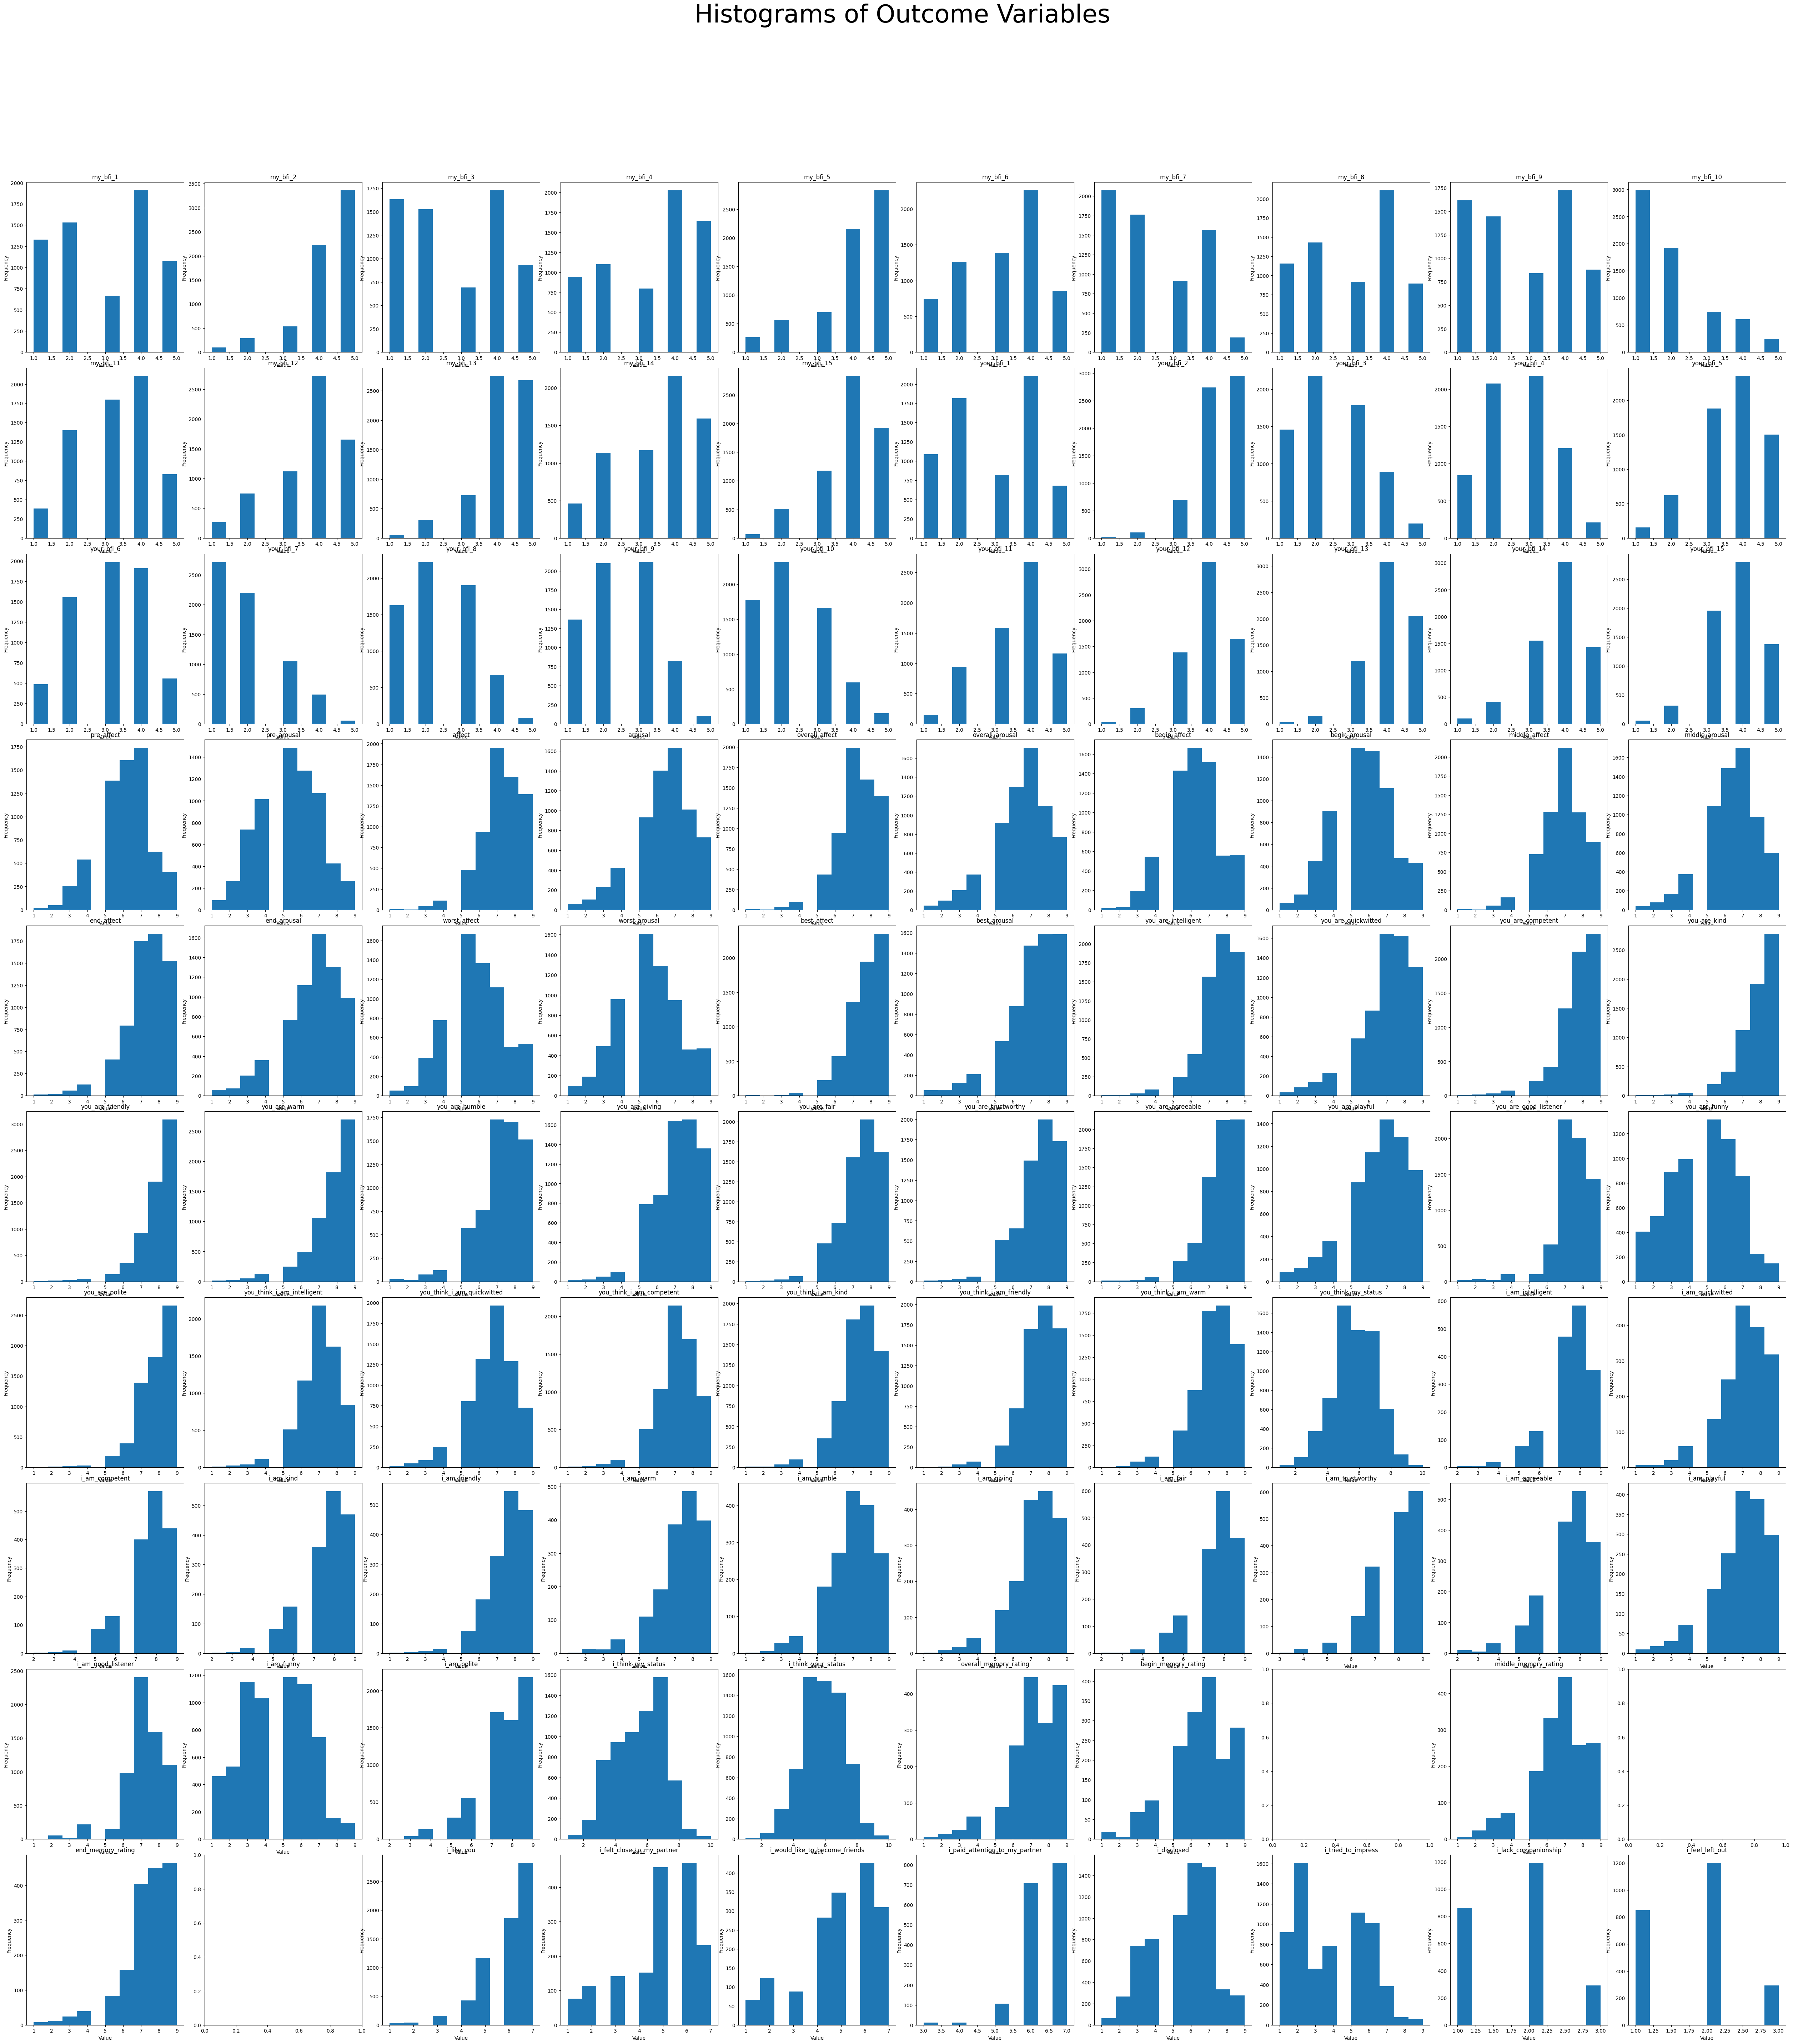

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
width, height = 10, 10
fig, ax = plt.subplots(height, width, figsize=(50, 60))
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.suptitle("Histograms of Outcome Variables", fontsize=50)
indices = [[x for x in range(width)] for i in range(height)]
imdices_y = [[y for y in range(height)] for i in range(width)]

a=0


# loop through all outcomes
for i in range(height):
  for j in range(width):
    col=outcomes[(width*i)+j]
    try:
      ax[i][j].hist(df[col], bins=10)
      ax[i][j].set_title(col)
      ax[i][j].set_xlabel("Value")
      ax[i][j].set_ylabel("Frequency")
    except:
      print(col)
plt.show()

## Correlation

In [21]:
df.corr().abs().unstack()

survey_duration_in_seconds  survey_duration_in_seconds    1.000000
                            time_zone                     0.004787
                            pre_affect                    0.002322
                            pre_arousal                   0.004531
                            technical_quality             0.024250
                                                            ...   
backchannel_count           your_neurotic                 0.045480
                            your_open                     0.106328
                            backchannel_given             0.644520
                            backchannel_recieved          0.644520
                            backchannel_count             1.000000
Length: 43264, dtype: float64

In [22]:
df_corr = df.corr()
df_corr

,survey_duration_in_seconds,time_zone,pre_affect,pre_arousal,technical_quality,conv_length,affect,arousal,overall_affect,overall_arousal,...,my_neurotic,my_open,your_extraversion,your_agreeable,your_conscientious,your_neurotic,your_open,backchannel_given,backchannel_recieved,backchannel_count
survey_duration_in_seconds,1.000000,-0.004787,0.002322,0.004531,0.024250,0.013045,0.044957,0.038284,0.031892,0.014846,...,0.017332,0.042964,0.020508,0.011683,0.009083,-0.005055,0.022570,0.052040,0.052040,0.080743
time_zone,-0.004787,1.000000,-0.076723,-0.041572,0.031562,-0.016069,-0.040956,-0.018547,-0.034666,-0.027621,...,0.043340,-0.001687,-0.005596,-0.041952,-0.076166,0.074768,-0.004217,-0.003097,-0.003097,-0.004802
pre_affect,0.002322,-0.076723,1.000000,0.516117,-0.047226,0.035190,0.413807,0.355937,0.353099,0.310451,...,-0.374710,0.081580,0.054186,0.102637,0.111347,-0.116140,0.076069,0.010600,0.010600,0.016446
pre_arousal,0.004531,-0.041572,0.516117,1.000000,-0.040569,0.037791,0.309955,0.465021,0.263820,0.413382,...,-0.235210,0.039679,0.079791,0.047053,0.092143,-0.091882,0.074500,0.011133,0.011133,0.017273
technical_quality,0.024250,0.031562,-0.047226,-0.040569,1.000000,0.028162,-0.085644,-0.092416,-0.079950,-0.070530,...,0.085162,0.009590,-0.019616,-0.060525,-0.067760,0.053479,-0.036139,-0.034942,-0.034942,-0.054219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your_neurotic,-0.005055,0.074768,-0.116140,-0.091882,0.053479,-0.026696,-0.225984,-0.167243,-0.250712,-0.172142,...,0.249494,-0.031300,-0.273169,-0.326340,-0.534990,1.000000,-0.276081,-0.029278,-0.029278,-0.045480
your_open,0.022570,-0.004217,0.076069,0.074500,-0.036139,0.028986,0.338657,0.197236,0.344653,0.220023,...,-0.038162,0.195991,0.247146,0.404513,0.358286,-0.276081,1.000000,0.068448,0.068448,0.106328
backchannel_given,0.052040,-0.003097,0.010600,0.011133,-0.034942,0.049505,0.108886,0.061068,0.087891,0.056081,...,-0.012217,0.032731,0.056760,0.070541,0.048483,-0.029278,0.068448,1.000000,-0.169189,0.644520
backchannel_recieved,0.052040,-0.003097,0.010600,0.011133,-0.034942,0.049505,0.108886,0.061068,0.087891,0.056081,...,-0.012217,0.032731,0.056760,0.070541,0.048483,-0.029278,0.068448,-0.169189,1.000000,0.644520


In [23]:
sorted(df_corr["backchannel_count"].dropna())

[-0.13029943348481537,
 -0.12940733523315887,
 -0.12233728147843417,
 -0.12047196019965463,
 -0.09967122921867916,
 -0.09091497767802921,
 -0.08823444164481034,
 -0.08148792968718185,
 -0.08138983237439933,
 -0.07656047316344508,
 -0.06946066375255346,
 -0.06881323567720445,
 -0.06763500673342361,
 -0.06700281412656064,
 -0.0643853118500343,
 -0.06336461559124223,
 -0.057187263055358956,
 -0.056265966898658176,
 -0.05421896239368209,
 -0.0522875001175054,
 -0.052006244291882414,
 -0.05034659088273123,
 -0.048242241606186995,
 -0.04553989040611588,
 -0.045480138484762934,
 -0.045257202938005926,
 -0.044981256787897966,
 -0.04237721339142939,
 -0.03857202302335416,
 -0.03584383346413073,
 -0.035315562680308256,
 -0.034732529799832046,
 -0.03386246218963886,
 -0.029075783003717024,
 -0.027387850774235223,
 -0.026555536007397726,
 -0.022352882001655895,
 -0.0216297427940894,
 -0.020886496550466732,
 -0.020636546502320254,
 -0.018977947434130386,
 -0.018255355311274816,
 -0.0176855180621900

<AxesSubplot:>

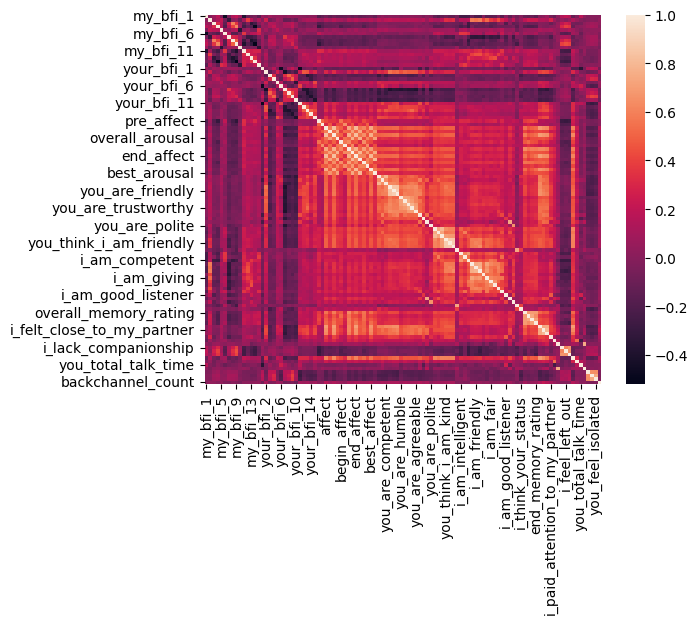

In [24]:
sns.heatmap(df[outcomes+["backchannel_count"]].corr())

# EDA - Backchannel

In [35]:
def get_var_description(var):
    return datadict[datadict['column']==var].iloc[0]['text']

In [44]:
def get_lin_reg(var_y, df, var_x='backchannel_count'):
    reg = smf.ols(f'{var_y} ~ {var_x}', data = df).fit()
    plt.figure()
    sns.regplot(y=var_y, x=var_x, data=df)
    try:
        description = get_var_description(var_y)
    except:
        description = ""
    plt.title(f"Change in {var_y} with change in {var_x} \n '{description}'")
    return()
    # save_file = f"{savedir}/{var_x}_{var_y}_linreg.png"
    # plt.savefig(save_file)
    # print(f"Saved {save_file}")
    # if showfig:
    #     plt.show()

In [50]:
def save_lin_reg(var_y, df,savedir = "figures", var_x='backchannel_count'):
    reg = smf.ols(f'{var_y} ~ {var_x}', data = df).fit()
    plt.figure()
    sns.regplot(y=var_y, x=var_x, data=df)
    try:
        description = get_var_description(var_y)
    except:
        description = ""
    plt.title(f"Change in {var_y} with change in {var_x} \n '{description}'")
    save_file = rf"{savedir}\{var_x}_{var_y}_linreg.png"
    # plt.savefig(save_file)
    print(f"Saved {save_file}")
    plt.close()
    return reg

In [51]:
for outcome in outcomes:
    reg = save_lin_reg(outcome, df)
    print(outcome, get_var_description(outcome))
    reg.summary()

Saved figures\backchannel_count_my_bfi_1_linreg.png
my_bfi_1 I am someone who...
Saved figures\backchannel_count_my_bfi_2_linreg.png
my_bfi_2 I am someone who...
Saved figures\backchannel_count_my_bfi_3_linreg.png
my_bfi_3 I am someone who...
Saved figures\backchannel_count_my_bfi_4_linreg.png
my_bfi_4 I am someone who...
Saved figures\backchannel_count_my_bfi_5_linreg.png
my_bfi_5 I am someone who...
Saved figures\backchannel_count_my_bfi_6_linreg.png
my_bfi_6 I am someone who...
Saved figures\backchannel_count_my_bfi_7_linreg.png
my_bfi_7 I am someone who...
Saved figures\backchannel_count_my_bfi_8_linreg.png
my_bfi_8 I am someone who...
Saved figures\backchannel_count_my_bfi_9_linreg.png
my_bfi_9 I am someone who...
Saved figures\backchannel_count_my_bfi_10_linreg.png
my_bfi_10 I am someone who...
Saved figures\backchannel_count_my_bfi_11_linreg.png
my_bfi_11 I am someone who...
Saved figures\backchannel_count_my_bfi_12_linreg.png
my_bfi_12 I am someone who...
Saved figures\backchan

ValueError: endog has evaluated to an array with multiple columns that has shape (1644, 822). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [47]:
import ipywidgets as widgets
graph = widgets.interactive(get_lin_reg,df=widgets.fixed(df), var_y = outcomes, var_x = ["backchannel_count", "backchannel_given"])
display(graph)

interactive(children=(Dropdown(description='var_y', options=('my_bfi_1', 'my_bfi_2', 'my_bfi_3', 'my_bfi_4', '…

### Responsive Variables

In [ ]:
responsive_outcomes = list(filter(re.compile("^.*responsive.*$").match, df.columns))
responsive_outcomes

In [ ]:
df["responsive_sum"] = df["responsive"] + df["responsive_1"]+df["responsive_2"]+df["responsive_3"]
df["responsive_mean"] = df["responsive_sum"] / len(responsive_outcomes)

In [ ]:
reg = get_lin_reg(df, var_y = "responsive_mean", description="Mean of responsive variables")


In [ ]:
for var in responsive_outcomes:
    reg = get_lin_reg(df, var_y=var, description=get_var_description(var))
    print(reg.mse_resid)
    print("\n")

In [ ]:
cols = ['i_felt_close_to_my_partner' 'i_would_like_to_become_friends'
 'i_paid_attention_to_my_partner' 'my_partner_paid_attention_to_me'
 'my_partner_was_clear_and_coherent']
df["rate_conv"] = df['i_felt_close_to_my_partner'] + df['i_would_like_to_become_friends'] + df['i_paid_attention_to_my_partner'] + df['my_partner_paid_attention_to_me'] + df['my_partner_was_clear_and_coherent']


In [ ]:
affect_arousal_outcomes =  ['pre_affect', 'pre_arousal', 'affect', 'arousal', 'overall_affect', 'overall_arousal', 'begin_affect', 'begin_arousal', 'middle_affect', 'middle_arousal', 'end_affect', 'end_arousal', 'worst_affect', 'worst_arousal', 'best_affect', 'best_arousal']
df["affect_arousal"] = df["pre_affect"] + df["pre_arousal"] + df["affect"] + df["arousal"] + df["overall_affect"] + df["overall_arousal"] + df["begin_affect"] + df["begin_arousal"] + df["middle_affect"] + df["middle_arousal"] + df["end_affect"] + df["end_arousal"] + df["worst_affect"] + df["worst_arousal"] + df["best_affect"] + df["best_arousal"]
sns.regplot(y='affect_arousal', x='backchannel_count', data=df)
plt.show()

# Other EDA

In [ ]:
df["pre_affect"]
df["begin_affect"]
df["middle_affect"]
df["end_affect"]

fig = plt.figure(figsize=(20, 10))
plt.hist(df["pre_affect"], label = "pre_affect", bins = 20)
plt.hist(df["begin_affect"], label = "begin_affect", bins = 20)
plt.hist(df["middle_affect"], label = "middle_affect", bins = 20)
plt.hist(df["end_affect"], label = "end_affect", bins = 20)
plt.legend()
plt.show()
#boxplot